In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
import seaborn as sns
plt.style.use("fivethirtyeight")

In [2]:
df = pd.read_csv("/home/parth/Downloads/slc_106.csv")
df.head()

,Date,V RY (Volt),V YB (Volt),V BR (Volt),Cumulative KiloWatt Hrs (kWh),IR (Amp),IY (Amp),IB (Amp),Power (Kilowatt),Mode,...,Run Hours (Hrs),R_Bulb Failure (nos),Y_Bulb Failure (nos),B_Bulb Failure (nos),Feeder,MCB,L-R,Door,CONTACTOR FEEDBACK ERROR,Power
0,16/06/20,228.62,240.39,231.59,5221.1,0.08,0.0,0.00,0.0,Astro Clock,...,5.44,0.0,0.0,0.0,OFF,Normal,Remote,CLOSE,Normal,Normal
1,16/06/20,231.36,246.41,233.51,5221.1,0.08,0.0,0.00,0.0,Astro Clock,...,5.44,0.0,0.0,0.0,OFF,Normal,Remote,CLOSE,Normal,Normal
2,16/06/20,228.33,248.58,235.11,5221.1,0.08,0.0,0.01,0.0,Astro Clock,...,5.44,0.0,0.0,0.0,OFF,Normal,Remote,CLOSE,Normal,Normal
3,16/06/20,233.63,242.99,237.39,5221.1,0.08,0.0,0.00,0.0,Astro Clock,...,5.44,0.0,0.0,0.0,OFF,Normal,Remote,CLOSE,Normal,Normal
4,16/06/20,223.87,226.77,216.73,5221.1,0.08,0.0,0.00,0.0,Astro Clock,...,5.44,0.0,0.0,0.0,OFF,Normal,Remote,CLOSE,Normal,Normal


In [3]:
df.Feeder.replace(('ON', 'OFF'), (1, 0), inplace=True)
df = df.drop('Power', axis=1)
df.shape

(8185, 21)

In [4]:
df.head()

,Date,V RY (Volt),V YB (Volt),V BR (Volt),Cumulative KiloWatt Hrs (kWh),IR (Amp),IY (Amp),IB (Amp),Power (Kilowatt),Mode,...,Frequncy (Hz),Run Hours (Hrs),R_Bulb Failure (nos),Y_Bulb Failure (nos),B_Bulb Failure (nos),Feeder,MCB,L-R,Door,CONTACTOR FEEDBACK ERROR
0,16/06/20,228.62,240.39,231.59,5221.1,0.08,0.0,0.00,0.0,Astro Clock,...,50.02,5.44,0.0,0.0,0.0,0.0,Normal,Remote,CLOSE,Normal
1,16/06/20,231.36,246.41,233.51,5221.1,0.08,0.0,0.00,0.0,Astro Clock,...,50.08,5.44,0.0,0.0,0.0,0.0,Normal,Remote,CLOSE,Normal
2,16/06/20,228.33,248.58,235.11,5221.1,0.08,0.0,0.01,0.0,Astro Clock,...,50.04,5.44,0.0,0.0,0.0,0.0,Normal,Remote,CLOSE,Normal
3,16/06/20,233.63,242.99,237.39,5221.1,0.08,0.0,0.00,0.0,Astro Clock,...,50.06,5.44,0.0,0.0,0.0,0.0,Normal,Remote,CLOSE,Normal
4,16/06/20,223.87,226.77,216.73,5221.1,0.08,0.0,0.00,0.0,Astro Clock,...,50.00,5.44,0.0,0.0,0.0,0.0,Normal,Remote,CLOSE,Normal


In [5]:
df.rename(columns = {'Power (Kilowatt)' : 'Power', 'Run Hours (Hrs)' : 'Burn_hrs'}, inplace=True)

In [6]:
df.dtypes

Date                              object
V RY (Volt)                      float64
V YB (Volt)                      float64
V BR (Volt)                      float64
Cumulative KiloWatt Hrs (kWh)    float64
IR (Amp)                         float64
IY (Amp)                         float64
IB (Amp)                         float64
Power                            float64
Mode                              object
Power Factor (PF)                float64
Frequncy (Hz)                    float64
Burn_hrs                         float64
R_Bulb Failure (nos)             float64
Y_Bulb Failure (nos)             float64
B_Bulb Failure (nos)             float64
Feeder                           float64
MCB                               object
L-R                               object
Door                              object
CONTACTOR FEEDBACK ERROR          object
dtype: object

In [7]:
df['Power'].shape

(8185,)

In [8]:
df['Feeder'].where(df['Feeder'] == 0).count()

4566

In [9]:
df['Power'].where(df['Power'] == 0).count()

4594

In [10]:
df.drop(df[(df['Power'] != 0) & (df['Feeder'] == 0)].index, inplace = True)

In [11]:
df.shape

(8164, 21)

In [12]:
df = df[['Date' , 'Power' , 'Burn_hrs']]
df.dtypes

Date         object
Power       float64
Burn_hrs    float64
dtype: object

In [13]:
def rolling_mean_plot(data, window):
    rolling_mean = data['Power'].rolling(window = window).mean()
    rolling_mean.plot(figsize=(20,10))
    plt.xlabel('Date')
    plt.ylabel('Rolling mean Power in kW')
    plt.grid(True)
    return rolling_mean

In [14]:
df = df.dropna()
date = []
Power = []
burn_hrs = []
add = 0
counter = 0
x = df.Date[0]
date.append(df.Date[0])
for i in range(df.Date.shape[0]):
    if (df.Power.values[i] == 0):
        continue
    
    if (x != df.Date.values[i]):
        x = df.Date.values[i]
        date.append(df.Date.values[i])
        max_burn_hr = max(burn_hrs)
        add = add/counter
        Power.append(add*max_burn_hr)
        burn_hrs.clear()
        add = 0
        counter = 0
    
    add += df.Power.values[i]
    counter += 1
    burn_hrs.append(df.Burn_hrs.values[i])
    
    if(i == df.Date.shape[0]-1):
        max_burn_hr = max(burn_hrs)
        add = add/counter
        Power.append(add*max_burn_hr)
        break


In [15]:
Date = np.array(date)
Power = np.array(Power)
date = Date.reshape(-1,1)
Power = Power.reshape(-1,1)
d = np.concatenate((date, Power), axis=1)

In [16]:
df = pd.DataFrame(d, columns=['Date', 'Power'])
df = df.astype({"Date": object, "Power": float})

In [17]:
print(df.shape)
df = df[::-1]
df

(281, 2)


,Date,Power
280,01/09/19,64.850800
279,02/09/19,60.067103
278,03/09/19,71.438706
277,04/09/19,71.417025
276,05/09/19,71.670787
...,...,...
4,12/06/20,60.934616
3,13/06/20,58.981050
2,14/06/20,52.886895
1,15/06/20,58.859833


In [18]:
print(df['Power'].isnull().values.any())
print(df['Power'].eq(0).any().any())

False
False


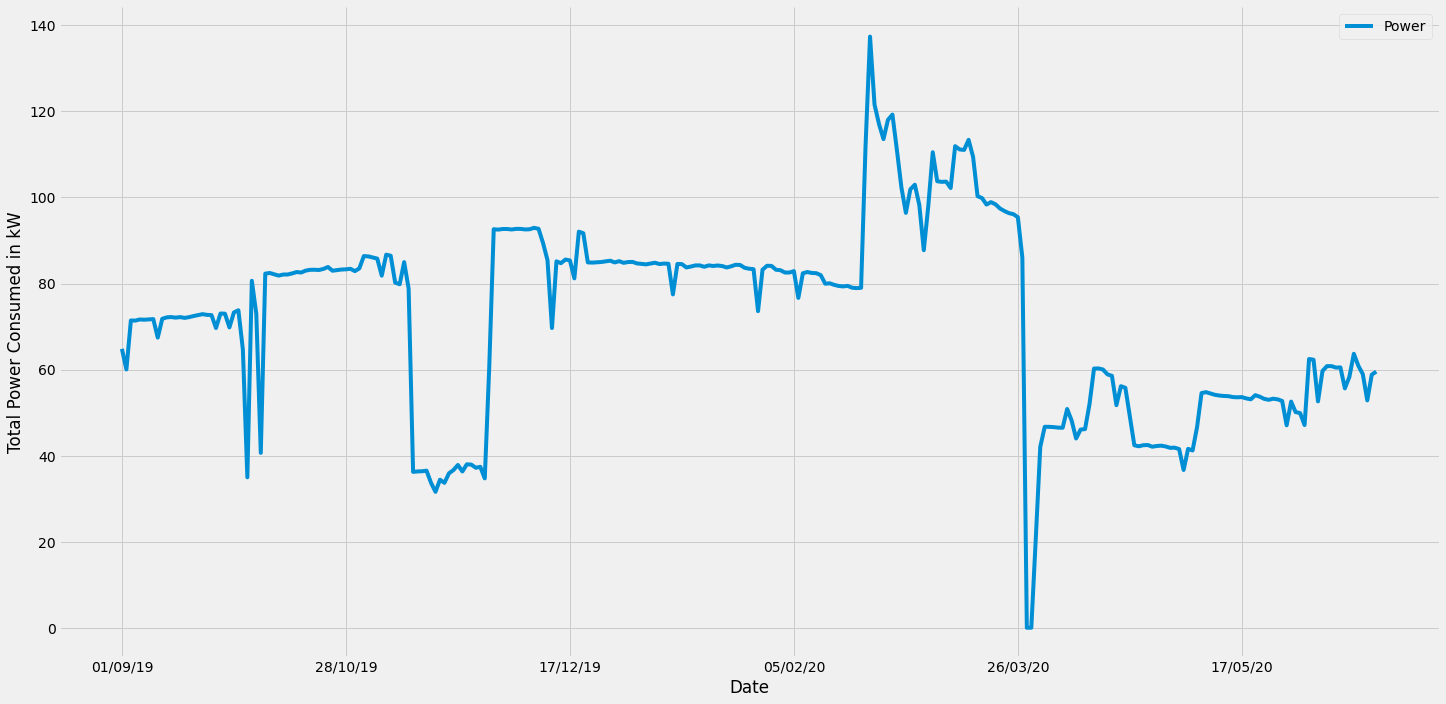

In [19]:
# plt.figure(figsize=(100,50))
# plt.plot_date(dat_2.Date, dat_2.Power, linestyle='solid', color='violet')
# plt.gcf().autofmt_xdate()
# plt.tight_layout()
# plt.grid(True)
df1=df.loc[:,['Date','Power']]
df1.set_index('Date',inplace=True)
df1.plot(figsize=(20,10))
plt.legend().set_visible(True)
plt.tight_layout()
sns.despine(top=True)
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Total Power Consumed in kW')

# dat_1.plot()
plt.show()

Date
01/09/19    64.850800
02/09/19    62.379223
03/09/19    65.602534
04/09/19    67.204638
05/09/19    68.220795
              ...    
12/06/20    56.086890
13/06/20    56.273610
14/06/20    56.055112
15/06/20    56.236062
16/06/20    56.451118
Name: Power, Length: 281, dtype: float64

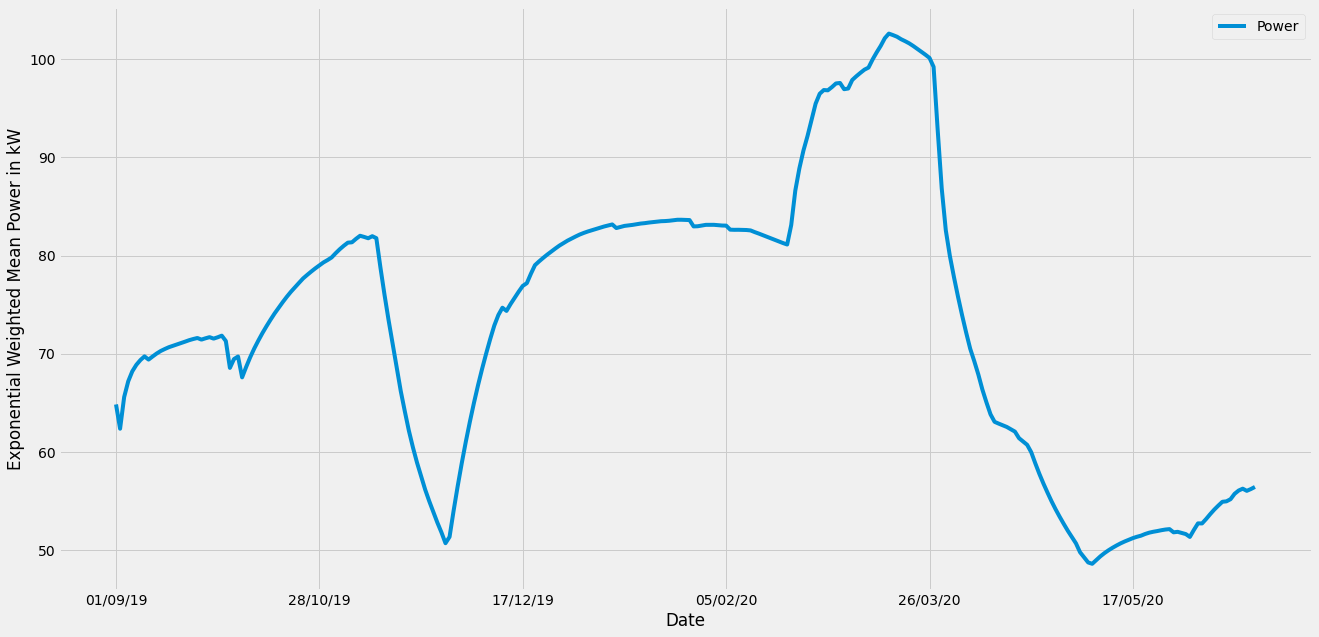

In [20]:
ewa=df1.Power.ewm(span=30,adjust=True).mean()
ewa.plot(figsize=(20,10))
plt.grid(True)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Exponential Weighted Mean Power in kW')
ewa

280          NaN
279          NaN
278          NaN
277          NaN
276          NaN
         ...    
4      60.078753
3      59.813281
2      58.724743
1      58.483833
0      59.040009
Name: Power, Length: 281, dtype: float64

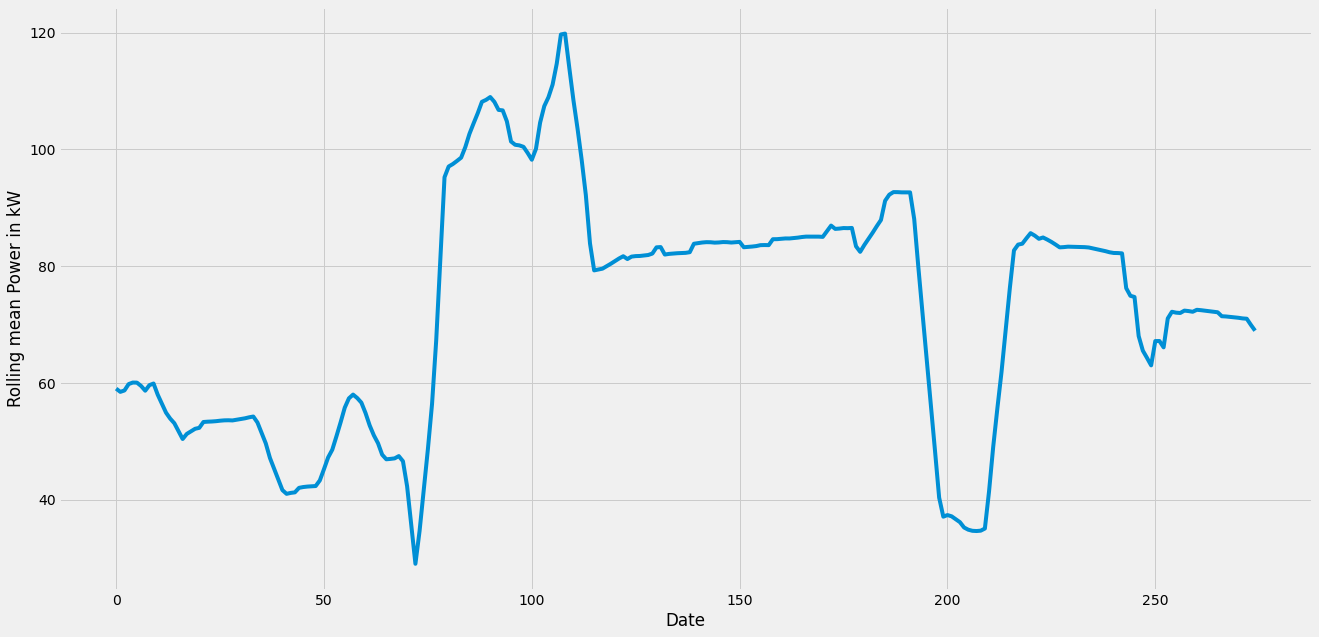

In [21]:
rolling_mean_plot(df, 7)

In [22]:
dataset = df.Power.values #numpy.ndarray
dataset = dataset.astype('float64')
dataset = np.reshape(dataset, (-1, 1))

# Normalizing or scaling the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Splitting the dataset in train and corss-validation set
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# Function to create a dataset for LSTM network where X contain value at (t-1) and Y contain value at time t
# look_back = no. of time steps
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    dataX = np.array(dataX)
    dataY = np.array(dataY)
    
#     dataY = dataY.reshape(dataY.shape[0],-1)
#   For LSTM n/w the input must be of type (samples, time step, features) so we reshape the data
    dataX = dataX.reshape(dataX.shape[0], look_back, -1)
    return dataX,dataY

In [23]:
look_back = 10
X_train,Y_train = create_dataset(train, look_back)

In [25]:
X_test, Y_test = create_dataset(test, look_back)

In [26]:
model = Sequential()
model.add(LSTM(10, input_shape = (X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.7))
model.add(LSTM((5)))
model.add(Dropout(0.7))
model.add(Dense(1))
model.compile(loss = 'mae', optimizer='adam', metrics = ['accuracy'])
hist = model.fit(X_train, Y_train, epochs=50, batch_size=1)

Epoch 1/50
213/213 [==============================] - 1s 3ms/step - loss: 0.3426 - accuracy: 0.0047
Epoch 2/50
213/213 [==============================] - 1s 3ms/step - loss: 0.2186 - accuracy: 0.0094
Epoch 3/50
213/213 [==============================] - 1s 3ms/step - loss: 0.2059 - accuracy: 0.0094
Epoch 4/50
213/213 [==============================] - 1s 3ms/step - loss: 0.1725 - accuracy: 0.0047
Epoch 5/50
213/213 [==============================] - 1s 3ms/step - loss: 0.1501 - accuracy: 0.0047
Epoch 6/50
213/213 [==============================] - 1s 3ms/step - loss: 0.1400 - accuracy: 0.0047
Epoch 7/50
213/213 [==============================] - 1s 3ms/step - loss: 0.1099 - accuracy: 0.0047
Epoch 8/50
213/213 [==============================] - 1s 3ms/step - loss: 0.1097 - accuracy: 0.0047
Epoch 9/50
213/213 [==============================] - 1s 3ms/step - loss: 0.0932 - accuracy: 0.0047
Epoch 10/50
213/213 [==============================] - 1s 3ms/step - loss: 0.0951 - accuracy: 0.0047

In [28]:
hist.history['loss']

[0.34263521432876587,
 0.21855705976486206,
 0.205926775932312,
 0.17253749072551727,
 0.15009993314743042,
 0.13997547328472137,
 0.1098591685295105,
 0.10970879346132278,
 0.09319790452718735,
 0.09505714476108551,
 0.08749638497829437,
 0.08248710632324219,
 0.08561734110116959,
 0.08021475374698639,
 0.08503349125385284,
 0.07997770607471466,
 0.08359775692224503,
 0.07757367938756943,
 0.07847489416599274,
 0.08027667552232742,
 0.08276283740997314,
 0.0842788890004158,
 0.07518196851015091,
 0.07830332219600677,
 0.08091375976800919,
 0.07795073091983795,
 0.08126308023929596,
 0.07965623587369919,
 0.07461030036211014,
 0.07579713314771652,
 0.08083643764257431,
 0.07616777718067169,
 0.07677753269672394,
 0.07843772321939468,
 0.0796671211719513,
 0.07493099570274353,
 0.08210018277168274,
 0.07876916229724884,
 0.07393625378608704,
 0.07411712408065796,
 0.07885685563087463,
 0.07884284108877182,
 0.07390780746936798,
 0.07330447435379028,
 0.07199259102344513,
 0.078832551836

In [29]:
trainpred = model.predict(X_train)
testpred = model.predict(X_test)
# We Scaled the data before training so our o/p is between 0 to 1
# So now we will convert our data back to orignal type i.e. in Power(kW)
trainpred = scaler.inverse_transform(trainpred)
Y_train = scaler.inverse_transform([Y_train])
testpred = scaler.inverse_transform(testpred)
Y_test = scaler.inverse_transform([Y_test])

In [30]:
# Finding the RMSE
# import math
# print("The RMS error on training set is : ", math.sqrt(mean_squared_error(trainpred, Y_train.T)))
# print("The RMS error on test set is : ", math.sqrt(mean_squared_error(testpred, Y_test.T)))
print("The MAE error on training set is : ", mean_absolute_error(trainpred, Y_train.T))
print("The MAE error on test set is : ", mean_absolute_error(testpred, Y_test.T))

The MAE error on training set is :  8.09071696585333
The MAE error on test set is :  13.350258706459021


No handles with labels found to put in legend.


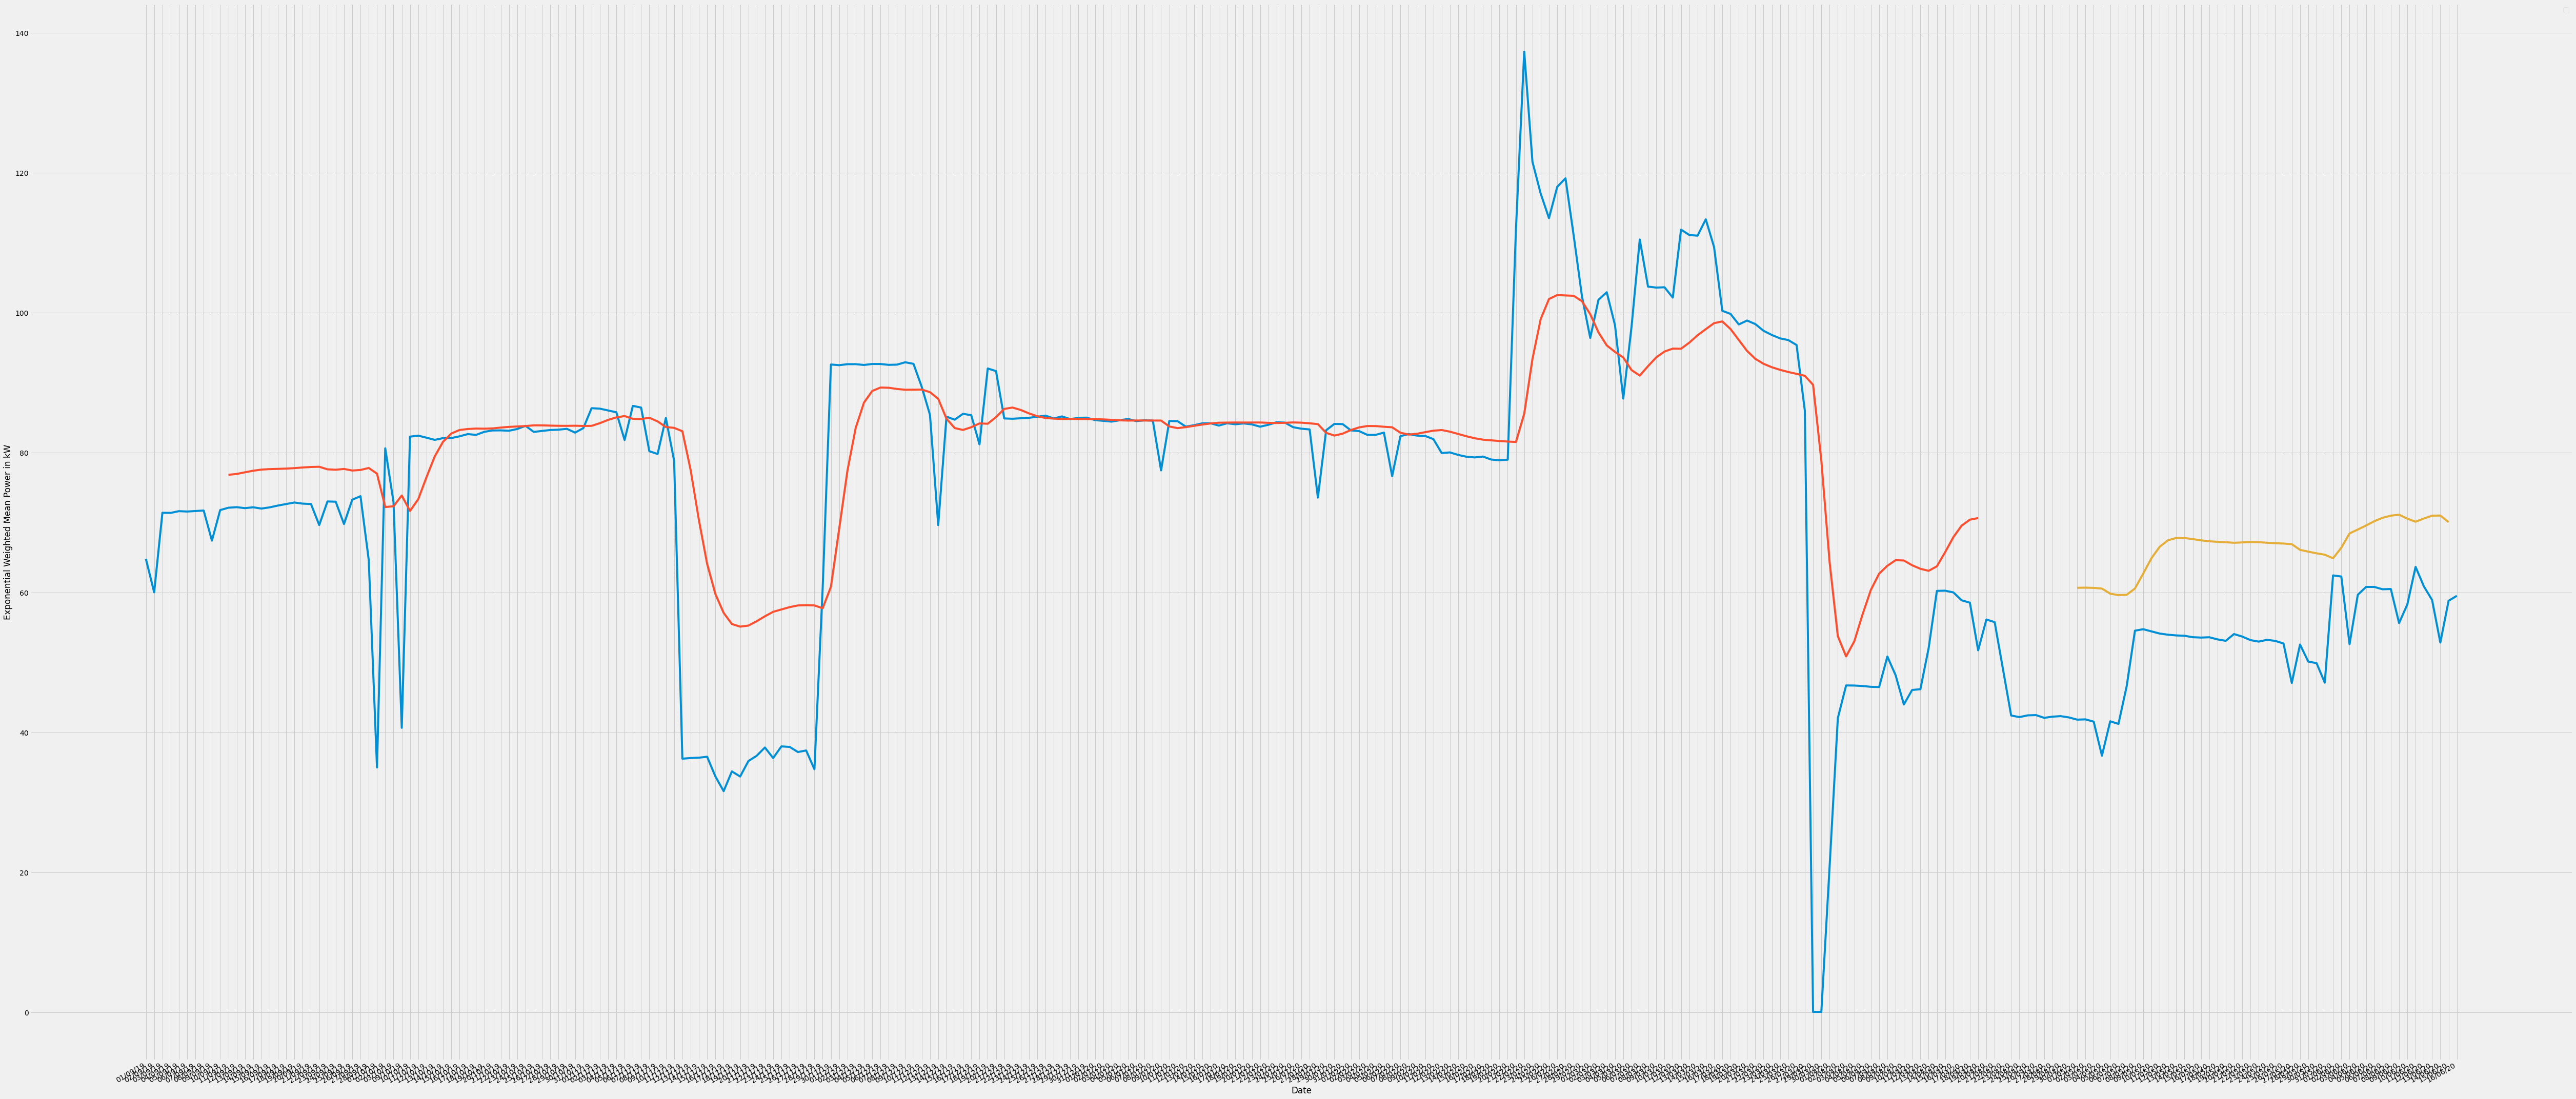

In [31]:
plt.figure(figsize=(70,30))
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainpred)+look_back, :] = trainpred
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainpred)+(look_back*2)+1:len(dataset)-1, :] = testpred
# plot baseline and predictions
plt.plot(df.Date.values, scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.grid(True)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Exponential Weighted Mean Power in kW')
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

## Predicting next 10 values 

In [45]:
trainpred.shape

(213, 1)

In [46]:
trainpred = model.predict(X_train)
# We Scaled the data before training so our o/p is between 0 to 1
# So now we will convert our data back to orignal type i.e. in Power(kW)
trainpred = scaler.inverse_transform(trainpred)
# Y_train = scaler.inverse_transform([Y_train])

In [47]:
# Finding the MAE
print("The MAE error on training set is : ", mean_absolute_error(trainpred, Y_train.T))

The MAE error on training set is :  8.09071696585333


In [48]:
b = dataset[-30:]
k = []
for i in range(0,30):
    m = b[-30:]
    m = m.reshape((1,30,1))
    a = model.predict(m)
    k.append(a)
    b = np.concatenate((b,a))


In [49]:
b.shape
k = np.array(k)
k=k.reshape((30,1))
t = scaler.inverse_transform(k)
t.shape

(30, 1)

No handles with labels found to put in legend.


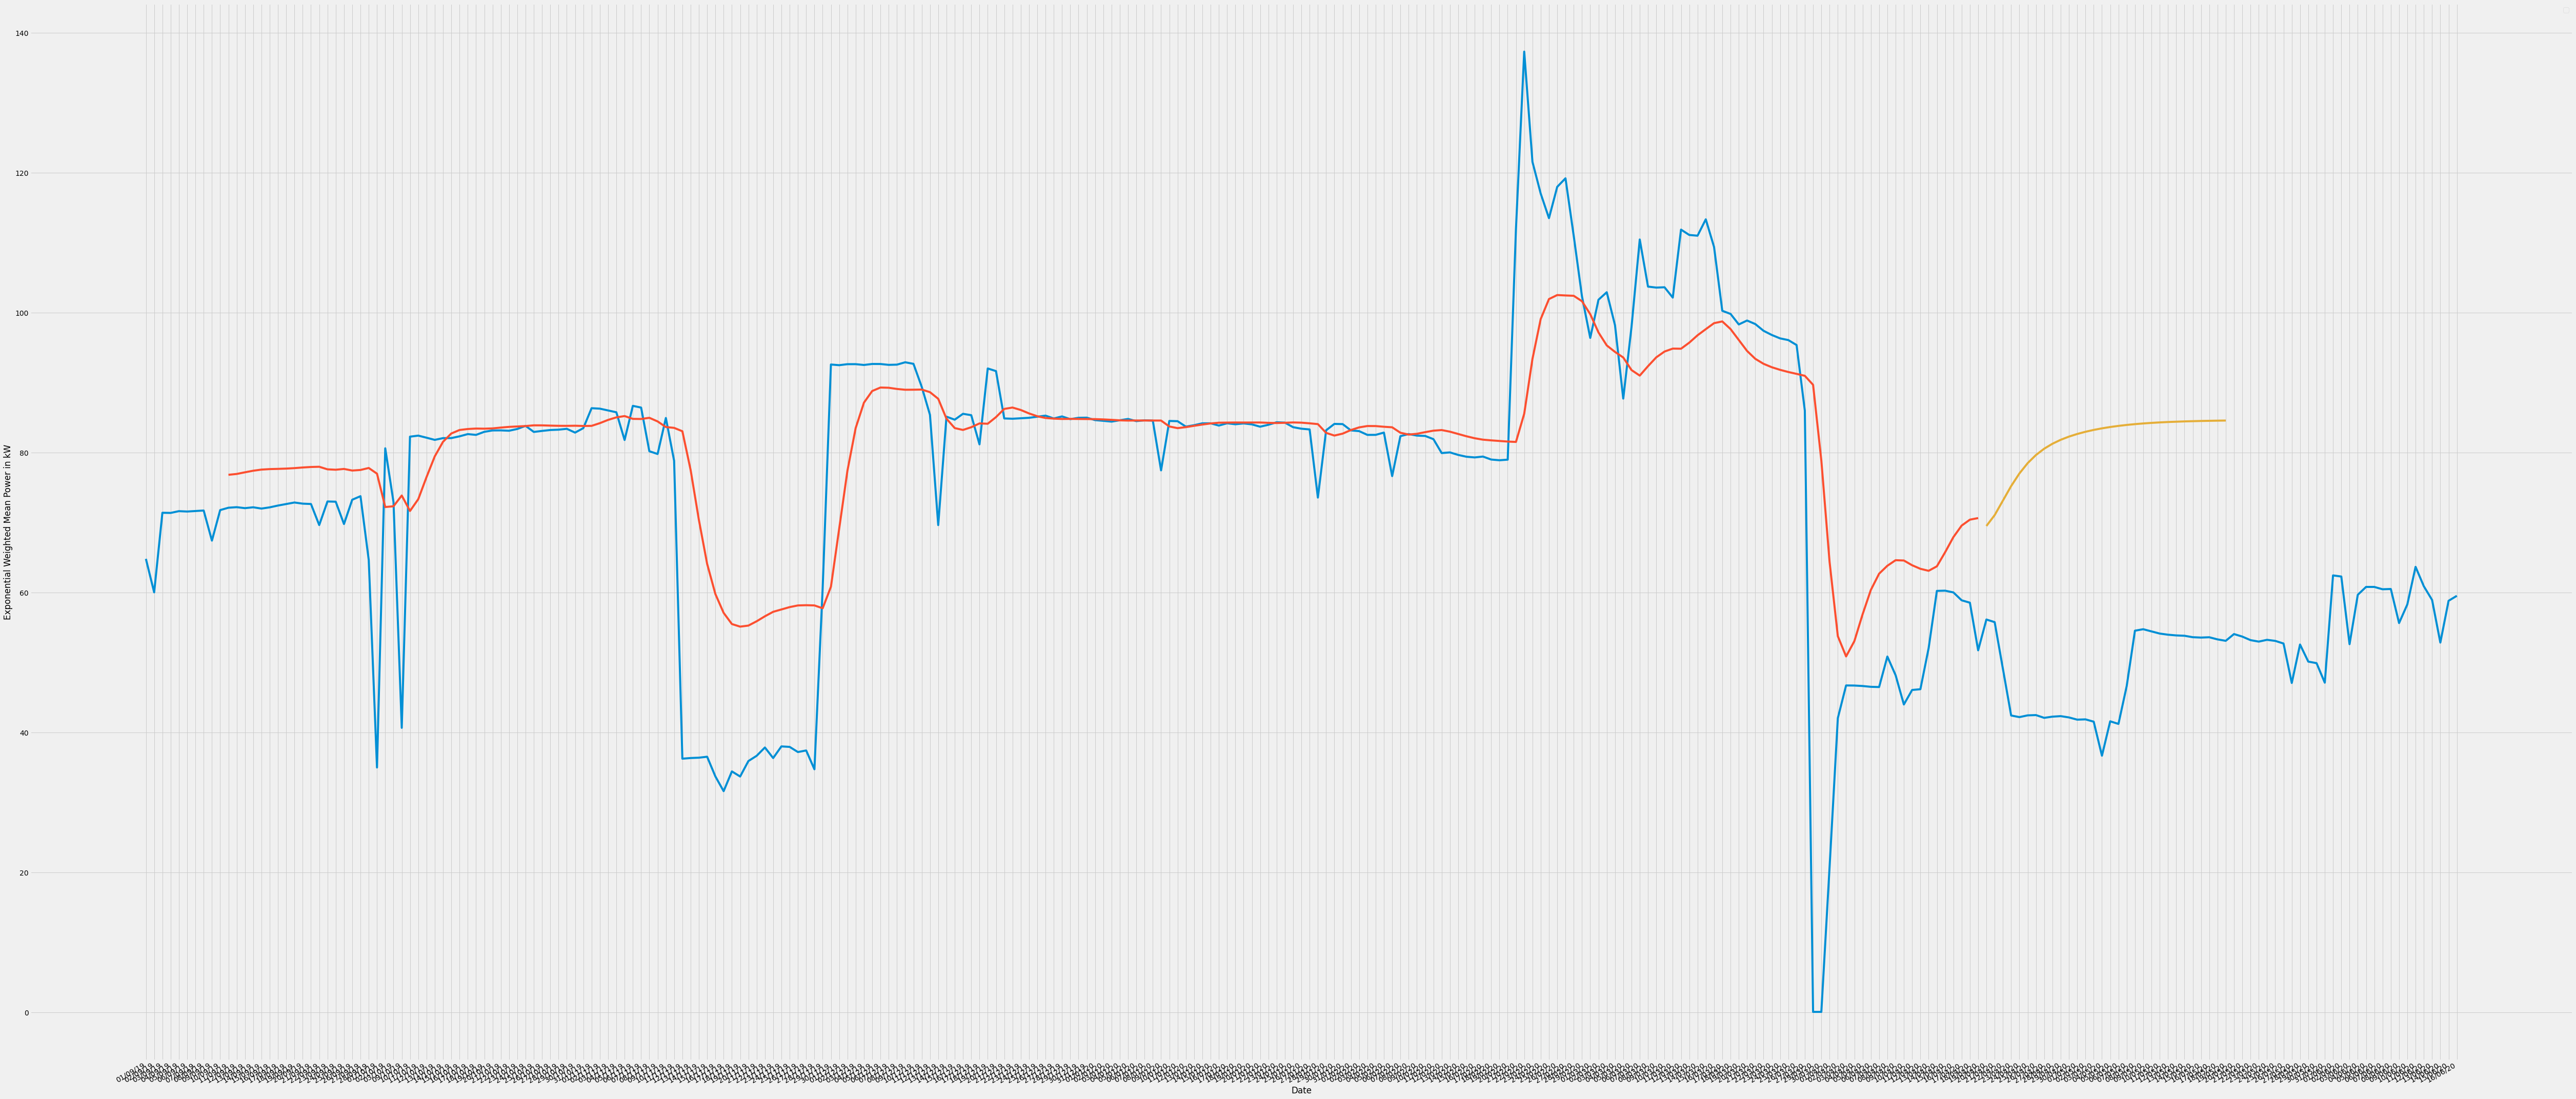

In [50]:
plt.figure(figsize=(70,30))
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainpred)+look_back, :] = trainpred

testPredictPlot = np.empty(((len(dataset)+30), 1))
testPredictPlot[:, :] = np.nan
testPredictPlot[(len(trainpred)+look_back):(len(trainpred)+look_back+30), :] = t

# plot baseline and predictions
plt.plot( df.Date.values, scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
# plt.plot(testPredictPlot)
plt.grid(True)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Exponential Weighted Mean Power in kW')
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

In [51]:
t

array([[69.550514],
       [71.10276 ],
       [73.187675],
       [75.25641 ],
       [77.06013 ],
       [78.530624],
       [79.68997 ],
       [80.59408 ],
       [81.3026  ],
       [81.86609 ],
       [82.32268 ],
       [82.69921 ],
       [83.01397 ],
       [83.27935 ],
       [83.50403 ],
       [83.694435],
       [83.85564 ],
       [83.99182 ],
       [84.106636],
       [84.20325 ],
       [84.28442 ],
       [84.35254 ],
       [84.409676],
       [84.45759 ],
       [84.49776 ],
       [84.531456],
       [84.55971 ],
       [84.583405],
       [84.60329 ],
       [84.619965]], dtype=float32)